## Setup

In [0]:
!mkdir utils

In [0]:
from utils.file_utils import *
from utils.image_utils import *
from utils.generator_utils import *
from utils.tqdm_utils import *
from utils.keras_utils import *

from config import config
from model import *

Using TensorFlow backend.


In [0]:
import os
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import collections
import google.colab as colab
import pickle
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

### Mount Google Drive

In [0]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root



ROOT_DIR =  mount_google_drive()
CHECKPOINT_ROOT = ROOT_DIR+ "/captioning/checkpoints/"
DATASET_DIR = ROOT_DIR + "/Dataset/"

if not os.path.exists(DATASET_DIR):
  os.makedirs(DATASET_DIR)

if not os.path.exists(CHECKPOINT_ROOT):
  os.makedirs(CHECKPOINT_ROOT)

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(4))

Mounted at /content/gdrive
/content/gdrive/My Drive/captioning/checkpoints/weights_4


## Load embeddings

In [0]:
def save_pickle(obj, fn):
	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		obj: the data object
		fn: the pickle file name
	# Returns
		Nothing. Just save to the file.
	'''
	with open(fn, "wb") as f:
		pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)


def read_pickle(fn):

	'''
	# Functionality
		Save the data into pickle format
	# Arguments
		fn: the pickle file name
	# Returns
		obj: the desired data object
	'''
	with open(fn, "rb") as f:
		return pickle.load(f)

In [0]:
# load prepared embeddings
train_img_embeds = read_pickle(DATASET_DIR + "train_img_embeds.pickle")
train_img_fns = read_pickle(DATASET_DIR + "train_img_fns.pickle")
val_img_embeds = read_pickle(DATASET_DIR + "val_img_embeds.pickle")
val_img_fns = read_pickle(DATASET_DIR + "val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(8278, 2048) 8278
(4050, 2048) 4050


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(DATASET_DIR)))

['train2014_sample.zip', 'val2014_sample.zip']

## Extract Labels (Captions)

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, DATASET_DIR + "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

In [0]:
# preview captions data
train_captions[:2]

[['A white plate with a brownie and white frosting.',
  'A piece of chocolate cake on top of a white plate.',
  'a chocolate cake and a fork ready to be eat',
  'A chocolate desert on a plate with a fork. ',
  'A piece of chocolate dessert on a plate with a napkin and a fork.'],
 ['a man with a beard and a brown and white dog on a leash',
  'A man and his dog on a hike - both wearing backpacks',
  'A man and a dog standing on a dirt path in the woods.',
  'a man carrying a back pack walking a dog carrying a back pack',
  'A man with a backpack holding a dog on a leash.']]

## Let's go to NLP Part now!

#### General Pipeline for captions of each image:
- Original Captions is a list of sentences of various lengths
-  Change every word to lower case
- Tokenize the senteces and build vocabulary (with specific threashold word frequencies). 
- Map each token to a number.
- Sentences then become list of list of numbers
- Pad and truncate the sequence of numbers to max len

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

  
  
def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    
    vocab_with_repeat = []
    for captions in train_captions:
      for sentence in captions:
        tokens = split_sentence(sentence)
        vocab_with_repeat += tokens
    counter = collections.Counter(vocab_with_repeat)
    
    vocab = []
    for element in counter:
      if counter[element] >= 5:
        vocab.append(element)
    vocab = list(set(vocab))
    vocab += [PAD, UNK, START, END]
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
    
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    res = []
    for instance in captions:
      instance_list = []
      
      for sentence in instance:
        sentence_list = []
        sentence_list.append(vocab[START])
        
        # append tokens
        tokens = split_sentence(sentence)
        for token in tokens:
          if token not in vocab.keys():
            sentence_list.append(vocab[UNK])
          else:
            sentence_list.append(vocab[token])
        
        sentence_list.append(vocab[END])
        
        instance_list.append(sentence_list)
      res.append(instance_list)

    return res

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

3066


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    ###YOUR CODE HERE###
    matrix = []
    
    if max_len:
      max_len = min(max_len, len(max(batch_captions, key=len)))  
    else:
      max_len = len(max(batch_captions, key=len))
    
    for caption in batch_captions:
      if len(caption) < max_len:
        output = caption + [pad_idx] * (max_len-len(caption))
      elif len(caption) > max_len:
        output = caption[:max_len]
      else:
        output = caption
      matrix.append(output)

    return np.array(matrix)

In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Define architecture,Train and Inference

In [0]:
input_data = (train_img_embeds, train_captions_indexed, val_img_embeds, val_captions_indexed)
model = Model(config, vocab, input_data, vocab[PAD], 9)

In [0]:
model.train()

[INFO] Training process started
**************************************************
Training loss: 3.958635
Epoch: 0, train loss: 3.9586354367733003, val loss: 3.3642323493957518
**************************************************
Training loss: 3.004894
Epoch: 1, train loss: 3.0048935914039614, val loss: 2.98721617937088
**************************************************
Training loss: 2.689189
Epoch: 2, train loss: 2.689189474105835, val loss: 2.8701721239089966
**************************************************
Training loss: 2.501467
Epoch: 3, train loss: 2.5014667828083037, val loss: 2.853787727355957
**************************************************
Training loss: 2.366350
Epoch: 4, train loss: 2.366349707841873, val loss: 2.812106263637543
**************************************************
Training loss: 2.258955
Epoch: 5, train loss: 2.2589551839828492, val loss: 2.836357927322388
**************************************************
Training loss: 2.159848
Epoch: 6, train loss: 2.

## Inference
Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

--2019-07-13 15:39:48--  https://cdn.pixabay.com/photo/2017/09/17/16/35/boats-2758962__340.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.82.97, 104.18.141.87, 2606:4700::6812:5261, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.82.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34676 (34K) [image/jpeg]
Saving to: ‘boats-2758962__340.jpg.1’

boats-2758962__340. 100%[===================>]  33.86K  --.-KB/s    in 0.003s  

2019-07-13 15:39:48 (10.6 MB/s) - ‘boats-2758962__340.jpg.1’ saved [34676/34676]

[INFO] Inference process started


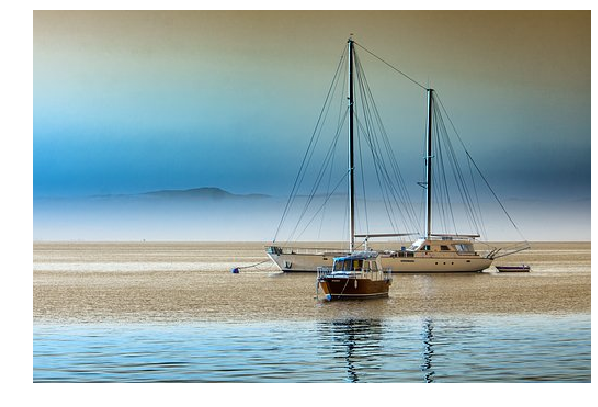

a group of boats in the water near a lake


In [0]:
! wget https://cdn.pixabay.com/photo/2017/09/17/16/35/boats-2758962__340.jpg
model.inference(cv2.imread("boats-2758962__340.jpg"))